In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


In [2]:
import os
import glob
import yaml
import pandas as pd

def report_model(path):
    info = torch.load(f'{path}/model_weight.ckpt', map_location='cpu')

    if not 'val_err' in info:
        overwrite_val_error(path)

    with open(f'{path}/config.yaml', 'r') as f:
        config = yaml.safe_load(f)

    ret = {
        'path': os.path.basename(path),
        'id': os.path.basename(path).replace('_all_counties', ''),
        'val_err': info['val_err'],
        'val_loss': info['val_loss'],
        'train_loss': info['train_loss'],
        'val_tmax': config['dataset']['val_tmax'],
        'num_train_counties': len(config['dataset']['train_counties']),
        'housing': config['model']['args']['use_housing']
    }

    dwargs = config['dataset']['kwargs']
    if dwargs['use_fill_frac']:
        ret['objective'] = 'Fill fraction'
    elif dwargs['use_max_scaling']:
        ret['objective'] = 'Relative density'
    else:
        ret['objective'] = 'Absolute density'
    return ret

records = []
for path in glob.glob('models/*'):
    if not os.path.isdir(path): continue
    record = report_model(path)
    if record is not None:
        records.append(record)

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values(by=['objective', 'val_err']).drop(columns='path').set_index(['objective', 'id'])

val_err  val_loss  train_loss  val_tmax  \
objective        id                                                    
Absolute density 3761106_1  0.009168  0.009168    0.000153        10   
                 3701409_1  0.009186  0.009186    0.000157        10   
                 3761106_0  0.009191  0.009191    0.000159        10   
                 3761096_1  0.009491  0.009491    0.000157        10   
                 3701409_0  0.009625  0.009625    0.000150        10   
                 3701261_0  0.009904  0.009904    0.000163        10   
                 3761096_0  0.010181  0.010181    0.000142        10   
                 3701258_0  0.010560  0.010560    0.000156        10   
                 3701375_0  0.011812  0.011812    0.000240        10   
Fill fraction    3761106_3  0.010325  0.652975    0.001368        10   
                 3761096_3  0.010759  0.632170    0.001423        10   
                 3701409_3  0.011859  0.590489    0.001454        10   
                 3701261_2  0.012043  0.614066    0.001455        10   
                 3761106_2  0.012099  0.901721    0.001516        10   
                 3701375_1  0.013700  0.616078    0.001377        10   
                 3701409_2  0.014605  0.647295    0.001397        10   
                 3701258_2  0.015661  0.646703    0.001319        10   
                 3761096_2  0.016621  0.614481    0.001328        10   
Relative density 3761106_5  0.007744  0.059136    0.000312        10   
                 3701409_5  0.008999  0.062450    0.000328        10   
                 3701261_1  0.010214  0.066285    0.000318        10   
                 3701258_1  0.011415  0.074592    0.000367        10   
                 3761096_4  0.011569  0.069344    0.000349        10   
                 3701409_4  0.011664  0.074218    0.000339        10   
                 3761106_4  0.012195  0.088287    0.000376        10   
                 3701375_2  0.012962  0.076484    0.000369        10   
                 3761096_5  0.013810  0.082111    0.000564        10   

                            num_train_counties  housing  
objective        id                                      
Absolute density 3761106_1                  31     True  
                 3701409_1                  31     True  
                 3761106_0                  31    False  
                 3761096_1                  31     True  
                 3701409_0                  31    False  
                 3701261_0                  31    False  
                 3761096_0                  31    False  
                 3701258_0                  31    False  
                 3701375_0                  31    False  
Fill fraction    3761106_3                  31     True  
                 3761096_3                  31     True  
                 3701409_3                  31     True  
                 3701261_2                  31    False  
                 3761106_2                  31    False  
                 3701375_1                  31    False  
                 3701409_2                  31    False  
                 3701258_2                  31    False  
                 3761096_2                  31    False  
Relative density 3761106_5                  31     True  
                 3701409_5                  31     True  
                 3701261_1                  31    False  
                 3701258_1                  31    False  
                 3761096_4                  31    False  
                 3701409_4                  31    False  
                 3761106_4                  31    False  
                 3701375_2                  31    False  
                 3761096_5                  31     True

# Saliency plotting

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342) 6.493155684322119 -10.940459571778774
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144) 5.788603035733104 -10.517342548351735
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150) 6.363399771973491 -13.078369922935963
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235) 6.583591196686029 -11.97804152034223
170.5 169.0


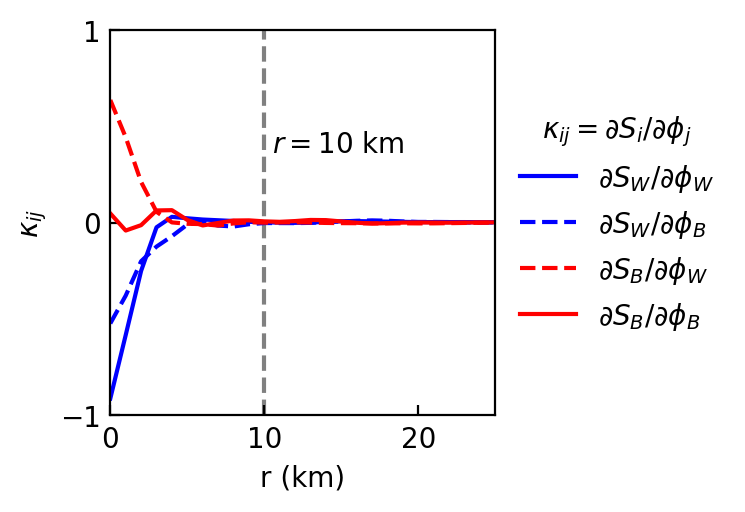

In [3]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

model_id = '3761106_5' # Best performing model trained on all counties

with h5py.File(f'models/{model_id}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape, np.max(G_s[-1]), np.min(G_s[-1]))

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa_{ij}$')
ax.set(
    xlim=[0, 25],
    ylim=[-1, 1],
    xticks=[0, 10, 20],
    yticks=[-1, 0, 1]
)
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 10
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5], title='$\\kappa_{ij} = \\partial S_i / \\partial \\phi_j$')

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)
170.5 169.0


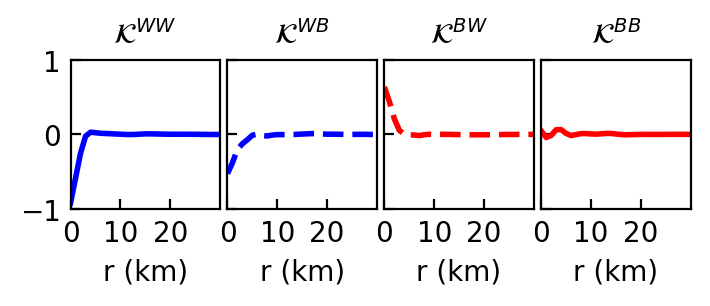

In [4]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

model_id = '3761106_5' # Best performing model trained on all counties

with h5py.File(f'models/{model_id}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 4, figsize=(4, 1), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    r'$\mathcal{K}^{WW}$',
    r'$\mathcal{K}^{WB}$',
    r'$\mathcal{K}^{BW}$',
    r'$\mathcal{K}^{BB}$',
]

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax[i].plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=2)
    ax[i].set_xlabel('r (km)')

    ax[i].set(
        xlim=[0, 30],
        ylim=[-1, 1],
        xticks=[0, 10, 20],
        yticks=[-1, 0, 1]
    )
    ax[i].set_aspect(np.ptp(ax[i].get_xlim()) / np.ptp(ax[i].get_ylim()))
    ax[i].tick_params(which='both', direction='in')
    ax[i].set_title(labels[i])

fig.subplots_adjust(wspace=0.05)
